In [1]:
import matplotlib.pyplot as plt
import dendropy
import csv
import baltic as bt
import numpy as np
from matplotlib import cm
import matplotlib.patches as mpatches

In [2]:
##data not shareable due to data privacy considerations
pc_metadata = "tree_metadata.csv"


### Get postcode to nuts mapping

In [3]:
postcodes = set()
seq_to_postcode = {}
with open(pc_metadata) as f:
    data = csv.DictReader(f)
    for l in data:
        name = l["name"]
        postcode = l["postcode"]
        if postcode != "":
            postcodes.add(postcode)
            seq_to_postcode[name] = postcode

In [4]:
pc_to_adm2 = {}
with open("../Data/postcode_to_adm2.tsv") as f:
    next(f)
    for l in f:
        toks = l.strip("\n").split("\t")
        pc_to_adm2[toks[0]] = toks[1]

In [11]:
adm2_to_nuts = {}
with open("../Data/nuts_to_adm2.tsv") as f:
    for l in f:
        toks = l.strip("\n").split("\t")
        nuts = toks[0]
        adm2s = toks[1:]
        for i in adm2s:
            if i != "" and i != "KENT":
                adm2_to_nuts[i] = nuts
            elif i == "KENT":
                adm2_to_nuts[i] = "KENT"


In [12]:
seq_to_nuts = {}
count = 0
for sequence, postcode in seq_to_postcode.items():
    adm2 = pc_to_adm2[postcode]
    if "|" not in adm2:
        nuts = adm2_to_nuts[adm2]
    else:
        nuts_set = set()
        adm_list = adm2.split("|")
        for i in adm_list:
            nuts_set.add(adm2_to_nuts[i])
        if len(nuts_set) == 1:
            nuts = list(nuts_set)[0]
        else:
            count += 1
            nuts = "|".join(nuts_set)
            
    seq_to_nuts[sequence] = nuts
        
        
        

In [13]:
with open("tree_metadata_with_nuts.csv", 'w') as fw:
    headers = ["name", "sample_date", "postcode", "nuts"]
    writer = csv.DictWriter(fw, fieldnames=headers)
    writer.writeheader()
    with open("tree_metadata.csv") as f:
        data = csv.DictReader(f)
        for l in data:
            write_dict = {}
            write_dict["name"] = l["name"]
            write_dict["sample_date"] = l["sample_date"]
            write_dict["postcode"] = l["postcode"]
            
            nuts = seq_to_nuts[l['name']]
            if "|" in nuts:
                write_dict["nuts"] = "Ambiguous"
            else:
                write_dict["nuts"] = nuts
                
            writer.writerow(write_dict)

In [14]:
possible_nuts = []
possible_nuts.append("KENT")
possible_nuts.append("GREATER_LONDON")
possible_nuts.append("SOUTH_EAST")
possible_nuts.append("EAST_OF_ENGLAND")
possible_nuts.append("SOUTH_WEST")
possible_nuts.append("EAST_MIDLANDS")
possible_nuts.append("WEST_MIDLANDS")
possible_nuts.append("YORKSHIRE_AND_THE_HUMBER")
possible_nuts.append("NORTH_WEST")
possible_nuts.append("NORTH_EAST")

for i in seq_to_nuts.values():
    if i not in possible_nuts:
        possible_nuts.append(i)
    


In [73]:
cmap = cm.get_cmap("viridis")

colors = cmap(np.linspace(0, 1,10))

nuts_colours = {}
count = 0
for nuts in possible_nuts:
    if "|" in nuts:
        nuts_colours[nuts] = 'dimgrey'
    elif nuts != "KENT" and nuts != "GREATER_LONDON":
        nuts_colours[nuts] = colors[count]
        count += 1
    else:
#         nuts_colours["KENT"] = np.array([0.6, 0.4, 0.8, 1.])
#         nuts_colours["GREATER_LONDON"] = np.array([0.502, 0., 0.502, 1.])
        nuts_colours["KENT"] = np.array([0., 0.478, 0.925, 1.])
        nuts_colours["GREATER_LONDON"] = np.array([0.99, 0.408, 0.357, 1.])
        


In [74]:
seq_colours = {}
for k,v in seq_to_nuts.items():
    seq_colours[k] = nuts_colours[v]

### Plot tree

In [17]:
tree = bt.loadNexus("best_tree_contphylo_output.tree", absoluteTime=True)

In [75]:
tipsize = 10
c_func=lambda k: 'slategrey' ## colour of branches
l_func=lambda k: 'lightgrey' ## colour of dotted lines
z_func=lambda k: 100
b_func=lambda k: 0.5 #branch width
zo_func=lambda k: 99
zb_func=lambda k: 98
zt_func=lambda k: 97
s_func = lambda k: tipsize

co_func=lambda k: seq_colours[k.name]
outline_colour_func = lambda k: seq_colours[k.name]

kwargs={'ha':'left','va':'center','size':12}

x_attr = lambda k: k.absoluteTime
y_attr = lambda k: k.y

patch_list = []
added_amb = False
for nuts, colour in nuts_colours.items():
    if colour != "dimgrey":
        patch_list.append(mpatches.Patch(color=colour, label=nuts.title().replace("_"," ")))
    else:
        if not added_amb:
            patch_list.append(mpatches.Patch(color="dimgrey", label="Ambiguous"))
            added_amb = True


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


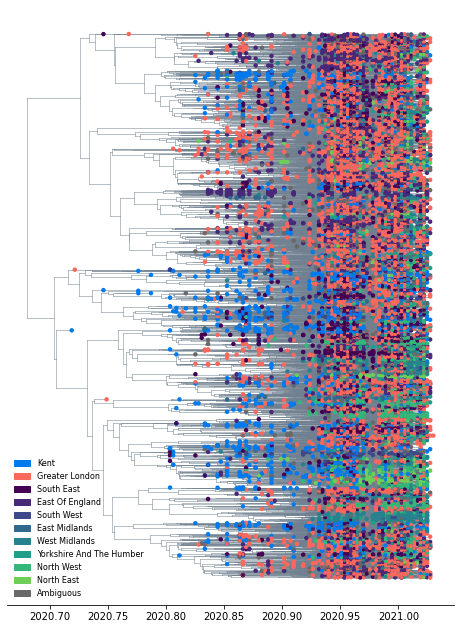

In [77]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 10

fig,ax = plt.subplots(figsize=(8,11),facecolor='w',frameon=False)
[ax.spines[loc].set_visible(False) for loc in ['top', 'right', 'left']]
ax.set_yticks([])

tree.plotTree(ax, colour_function=c_func, x_attr=x_attr, y_attr=y_attr, branchWidth=b_func)

tree.plotPoints(ax, x_attr=x_attr, size_function=s_func, colour_function=co_func, y_attr=y_attr, outline_colour=outline_colour_func)

ax.legend(handles=patch_list, loc="lower left",fontsize=8,frameon=False)

plt.savefig("tree_coloured_by_nuts.png")
plt.savefig("tree_coloured_by_nuts.pdf")
plt.savefig("tree_coloured_by_nuts.svg")

plt.show()